## Gael Blanchard
###  Problem: Given the Global Terrorism Data Set construct a predictive model which can determine which terrorist group is responsible for an event

## Global Terrorism Data
[Source: National Consortium for the Study of Terrorism and Responses to Terrorism (START). (2016). Global Terrorism Database [Data file]. Retrieved from https://www.start.umd.edu/gtd](http://www.start.umd.edu/gtd)

In [1]:
# Required Libraries
import numpy as np 
import pandas as pd 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, hamming_loss
import matplotlib.pyplot as plt

In [2]:
# Disables SettingWithCopy Warning
# and returns no column restriction
# when printing
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
# Set the random seed for reproducible results
np.random.seed(0)

# 1.   Data Collection & Preparation
* Read in our data from the Global Terrorism Database into a Pandas Data Frame
* Isolated the most descriptive features to use in our classifcation model (10/135 available)
* Imputed missing data
* Factorized features for usage in our classification model
* Seperated data into known and unknown perpetrators
* Defined our train and test sets

In [3]:
global_terrorism_data = pd.read_excel("globalterrorismdb_0617dist.xlsx")

In [4]:
# method to determine what
# features within a data
# source is valid or invalid
# then print
def determine_feature_validity(data_source):
    # initialize lists for valid
    # and invalid features
    valid_features = []
    invalid_features = []
    iterator = 0
    feature_names = data_source.columns.values
    invalid_data = data_source.isna().any()
    # For all data that is valid/invalid
    # add to appropriate list
    for invalid in invalid_data:
        if not invalid:
            valid_features.append(feature_names[iterator])
            iterator += 1
        else:
            invalid_features.append(feature_names[iterator])
            iterator +=1
    #Print our results
    print("Valid Features: ")
    print(valid_features)
    print("Invalid Features: ")
    print(invalid_features)
    return valid_features, invalid_features

In [5]:
# Retrieve valid and invalid features
# from the global terrorism data
features_valid, features_invalid = determine_feature_validity(global_terrorism_data)

Valid Features: 
['eventid', 'iyear', 'imonth', 'iday', 'extended', 'country', 'country_txt', 'region', 'region_txt', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr', 'multiple', 'success', 'suicide', 'attacktype1', 'attacktype1_txt', 'targtype1', 'targtype1_txt', 'gname', 'individual', 'weaptype1', 'weaptype1_txt', 'property', 'dbsource', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY']
Invalid Features: 
['approxdate', 'resolution', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'location', 'summary', 'alternative', 'alternative_txt', 'attacktype2', 'attacktype2_txt', 'attacktype3', 'attacktype3_txt', 'targsubtype1', 'targsubtype1_txt', 'corp1', 'target1', 'natlty1', 'natlty1_txt', 'targtype2', 'targtype2_txt', 'targsubtype2', 'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt', 'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt', 'corp3', 'target3', 'natlty3', 'natlty3_txt', 'gsubname', 'gname2', 'gsubname2', 'gname3', 'gsubname3', 'motive', '

Fortunately our desired feature for prediction is valid

Note: Besides gname there are gname2 and gname3 which may contain more perpetrator groups. We will need to impute later on.

In [6]:
#Describe our valid features
global_terrorism_data[features_valid].describe(include="all")

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,vicinity,crit1,crit2,crit3,doubtterr,multiple,success,suicide,attacktype1,attacktype1_txt,targtype1,targtype1_txt,gname,individual,weaptype1,weaptype1_txt,property,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
count,1.703500e+05,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350,170350.000000,170350,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350.000000,170350,170350.000000,170350,170350,170350.000000,170350.000000,170350,170350.000000,170350,170350.000000,170350.000000,170350.000000,170350.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,205,NaN,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,22,3454,NaN,NaN,12,NaN,26,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,Iraq,NaN,Middle East & North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Bombing/Explosion,NaN,Private Citizens & Property,Unknown,NaN,NaN,Explosives/Bombs/Dynamite,NaN,START Primary Collection,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,22130,NaN,46511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83073,NaN,39994,78306,NaN,NaN,86704,NaN,66785,NaN,NaN,NaN,NaN
mean,2.001776e+11,2001.709997,6.474365,15.466845,0.043634,132.526669,NaN,7.091441,NaN,0.067790,0.988441,0.992985,0.879818,-0.572069,0.134206,0.896396,0.033871,3.220211,NaN,8.399654,NaN,NaN,0.002483,6.428576,NaN,-0.505970,NaN,-4.583387,-4.510555,0.091083,-3.975128
std,1.314444e+09,13.144146,3.392364,8.817929,0.204279,112.848161,NaN,2.949206,NaN,0.286731,0.106888,0.083461,0.325175,2.526694,0.340875,0.304747,0.180899,1.891227,NaN,6.648615,NaN,NaN,0.049769,2.152366,NaN,3.095503,NaN,4.542694,4.630440,0.583166,4.691492
min,1.970000e+11,1970.000000,0.000000,0.000000,0.000000,4.000000,NaN,1.000000,NaN,-9.000000,0.000000,0.000000,0.000000,-9.000000,0.000000,0.000000,0.000000,1.000000,NaN,1.000000,NaN,NaN,0.000000,1.000000,NaN,-9.000000,NaN,-9.000000,-9.000000,-9.000000,-9.000000
25%,1.990053e+11,1990.000000,4.000000,8.000000,0.000000,75.000000,NaN,5.000000,NaN,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2.000000,NaN,3.000000,NaN,NaN,0.000000,5.000000,NaN,0.000000,NaN,-9.000000,-9.000000,0.000000,-9.000000
50%,2.007121e+11,2007.000000,6.000000,15.000000,0.000000,98.000000,NaN,6.000000,NaN,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,NaN,4.000000,NaN,NaN,0.000000,6.000000,NaN,1.000000,NaN,-9.000000,-9.000000,0.000000,0.000000
75%,2.014023e+11,2014.000000,9.000000,23.000000,0.000000,160.000000,NaN,10.000000,NaN,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,3.000000,NaN,14.000000,NaN,NaN,0.000000,6.000000,NaN,1.000000,NaN,0.000000,0.000000,0.000000,0.000000


To classify a terrorist incident, it is important to gather the most complete and desciptive features within our data. We want to determine who was involved in the incident, what were the characteristics of the incident, when and how long did the incident transpire, why the incident may have occured and how the incident occured.

Iyear, Country, Extended, AttackType1, TargType1, WeapType1, Multiple, Success and Suicide features allows us to have a fairly complete description of an event.

Features to discard:

Imonth and Iday are two unreliable features as they both contain 0 values. Vicinity,Doubtterr,Property,INT_LOG,INT_IDEO,INT_MISC and INT_ANY all contain negative values when they should be dichotomous features of either 0 or 1. Crit(1-3) while an interesting feature is far too reliant on conjecture.

We ignore certain features which exist for the purpose of citation and sourcing as they offer no insights into an actual terrorist incident(scite1,scite2,scite3,dbsource).

In [7]:
final_valid_candidates = ["iyear","country","extended",
                          "attacktype1","targtype1","weaptype1",
                          "multiple","success","suicide"
                         ]

In [8]:
#Describe our invalid features
global_terrorism_data[features_invalid].describe(include="all")

,approxdate,resolution,provstate,city,latitude,longitude,specificity,location,summary,alternative,alternative_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,related
count,7464,2219,155848,169904,165744.000000,165744.000000,170346.000000,47974,104212,26631.000000,26631,5630.000000,5630,374.000000,374,161005.000000,161005,127784,169714,168956.000000,168956,10018.000000,10018,9601.000000,9601,8990,9894,9706.000000,9706,1034.000000,1034,961.000000,961,884,1033,1006.000000,1006,5191,1740,149,269,13,48586,169971.000000,1681.000000,265.000000,99226.000000,100851.000000,104216.000000,16248.000000,16248,1617.000000,532.000000,532,263.000000,120.000000,120,4755.000000,150924.000000,150924,11843.000000,11843,10475.000000,10475,1660.000000,1660,1507.000000,1507,74.000000,74,71.000000,71,110965,160668.000000,105891.000000,103687.000000,155025.000000,105640.000000,101601.000000,60545.000000,60545,3.548700e+04,54431,170172.000000,12492.000000,12437.000000,3701.000000,7408.000000,313,3299,76313.000000,1.279000e+03,4.960000e+02,7.070000e+02,487.000000,471,9911.000000,9911,9322.000000,25439,104150,69585,39217,22845
unique,1833,1861,2494,33957,NaN,NaN,NaN,39816,101538,NaN,5,NaN,9,NaN,7,NaN,110,31299,82974,NaN,213,NaN,22,NaN,97,2474,4790,NaN,156,NaN,20,NaN,89,376,665,NaN,104,1098,383,58,103,13,13033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,9,NaN,NaN,8,NaN,NaN,29,NaN,11,NaN,28,NaN,10,NaN,23,NaN,5,NaN,16,18246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,18344,NaN,NaN,NaN,NaN,NaN,143,217,NaN,NaN,NaN,NaN,NaN,345,NaN,7,NaN,14150,75887,56562,32562,20829
top,"September 18-24, 2016",1998-08-04 00:00:00,Baghdad,Unknown,NaN,NaN,NaN,"The attack took place in Baghdad, Baghdad, Iraq.","09/00/2016: Sometime between September 18, 201...",NaN,Insurgency/Guerilla Action,NaN,Armed Assault,NaN,Facility/Infrastructure Attack,NaN,Unnamed Civilian/Unspecified,Unknown,Civilians,NaN,Iraq,NaN,Private Citizens & Property,NaN,Judge/Attorney/Court,Not Applicable,Civilians,NaN,Iraq,NaN,Private Citizens & Property,NaN,Unnamed Civilian/Unspecified,Not Applicable,Civilians,NaN,Iraq,Militants,Al-Nusrah Front,The Family,National Democratic Alliance Army (NDAA-ESSA),Islami Chhatra Shibir (ICS),Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Personal claim,NaN,NaN,Unknown,NaN,NaN,Unknown,NaN,NaN,Unknown Explosive Type,NaN,Firearms,NaN,Unknown Gun Type,NaN,Firearms,NaN,Unknown Gun Type,NaN,Firearms,NaN,Automatic Weapon,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Minor (likely < $1 million),NaN,It is unknown if any property was damaged in t...,NaN,NaN,NaN,NaN,NaN,Unknown,Colombia,NaN,NaN,NaN,NaN,NaN,0,NaN,Unknown,NaN,Casualty numbers for this incident conflict ac...,Committee on Government Operations United Stat...,"Christopher Hewitt, ""Political Violence and Te...","Christopher Hewitt, ""Political Violence and Te...","201612010023, 201612010024, 201612010025, 2016..."
freq,101,18,7238,9162,NaN,NaN,NaN,142,100,NaN,21324,NaN,3056,NaN,185,NaN,10842,14147,5810,NaN,21625,NaN,4937,NaN,2981,2780,2044,NaN,1647,NaN,467,NaN,273,242,160,NaN,124,480,56,20,15,1,14894,NaN,NaN,NaN

When analyzing invalid features data we are looking to determine which features can form multiple partitions(based on range or unique) but also has room for logical and accurate imputation.

Candidates: approxdate,resolution,city,latitude,longitude,location,summary,corp1,target1,natlty1,motive

In [9]:
# Create list with all candidates for addition into our
# most descriptive and defining features of our data
invalid_candidates = ["approxdate","resolution","city",
                      "latitude","longitude","location",
                      "summary","corp1","target1",
                      "natlty1","motive","provstate"
                     ]

In [10]:
# determine how many values need to be imputed before
# use as a defining feature of our data
for feature in invalid_candidates:
    # Counts number of null values
    # And determines percentage
    # of data missing for every
    # feature
    count = global_terrorism_data[feature].isnull().sum()
    total = global_terrorism_data.shape[0]
    fraction_missing = count / total
    percentage_missing = fraction_missing * 100
    print(feature,
          " Count: ",
          count,
          " Percentage of Data Missing: ",
          percentage_missing
         )

approxdate  Count:  162886  Percentage of Data Missing:  95.6184326387
resolution  Count:  168131  Percentage of Data Missing:  98.6973877311
city  Count:  446  Percentage of Data Missing:  0.261813912533
latitude  Count:  4606  Percentage of Data Missing:  2.70384502495
longitude  Count:  4606  Percentage of Data Missing:  2.70384502495
location  Count:  122376  Percentage of Data Missing:  71.8379806281
summary  Count:  66138  Percentage of Data Missing:  38.8247725271
corp1  Count:  42566  Percentage of Data Missing:  24.9873789257
target1  Count:  636  Percentage of Data Missing:  0.373348987379
natlty1  Count:  1394  Percentage of Data Missing:  0.818315233343
motive  Count:  121764  Percentage of Data Missing:  71.4787202818
provstate  Count:  14502  Percentage of Data Missing:  8.51306134429


In order to mantain the integrity of the data as much as possible we want to use features with less than one percent of data missing.

Resulting in(listed from greatest to lowest missing): Natlty1, Target1, City

In [11]:
final_invalid_candidates = ["natlty1","target1","city"]

In [12]:
# Method to return the top and bottom
# frequencies of features within a list
def frequency_data(data,features):
    for feature in features:
        print(feature)
        print(data[feature].value_counts().head())
        print(data[feature].value_counts().tail())

In [13]:
# List of features we want to view
# the frequencies of
freq_features = final_invalid_candidates + final_valid_candidates

In [14]:
# Determine frequencies of 
# our desired variable
frequency_data(global_terrorism_data,["gname"])

gname
Unknown                                             78306
Taliban                                              6575
Shining Path (SL)                                    4551
Islamic State of Iraq and the Levant (ISIL)          4287
Farabundo Marti National Liberation Front (FMLN)     3351
Name: gname, dtype: int64
Al Bayda Province of the Islamic State        1
Bini-Oru                                      1
Azadejan (Liberation)                         1
Uganda Federal Democratic Alliance (UFEDA)    1
Armed Fight for Workers Power                 1
Name: gname, dtype: int64


In [15]:
# return the frequencies
# of our final valid and invalid
# candidates
frequency_data(global_terrorism_data,freq_features)

natlty1
95.0     21625
153.0    13168
92.0     11110
4.0       9669
45.0      7783
Name: natlty1, dtype: int64
79.0     1
351.0    1
605.0    1
212.0    1
125.0    1
Name: natlty1, dtype: int64
target1
Civilians     5810
Unknown       4892
Soldiers      2688
Patrol        2616
Checkpoint    2562
Name: target1, dtype: int64
Business owned by Retired Air Force Offical    1
Office, U.N. High Commissioner for Refugees    1
Arish-Ashkelon Pipeline                        1
A parliamentarian                              1
15 Catholics                                   1
Name: target1, dtype: int64
city
Unknown    9162
Baghdad    7206
Karachi    2609
Lima       2358
Belfast    2140
Name: city, dtype: int64
Esquiroz       1
Peravurani     1
Oberon         1
Tekda Motla    1
Khamarkhel     1
Name: city, dtype: int64
iyear
2014    16860
2015    14852
2016    13488
2013    11996
2012     8500
Name: iyear, dtype: int64
1970    651
1974    580
1972    496
1973    473
1971    470
Name: iyear, dtype: 

Note: There are several classes with single instances for our desired feature gname

Upon reading the codebook Natlty1 and Target1 are reliant on one another. Imputation would be dangerous here because there is no logical way to infer the nationality of a target or the actual target of a terroist incident when not provided. Therefore they will be removed from consideration as defining features of the data.

In [16]:
# Our final candidates to 
# determine our data
final_candidates = freq_features
final_candidates.remove("natlty1")
final_candidates.remove("target1")
print(final_candidates)

['city', 'iyear', 'country', 'extended', 'attacktype1', 'targtype1', 'weaptype1', 'multiple', 'success', 'suicide']


In [17]:
# determine whether we need to apply
# any changes to data type for our
# final candidates
global_terrorism_data[final_candidates].dtypes

city           object
iyear           int64
country         int64
extended        int64
attacktype1     int64
targtype1       int64
weaptype1       int64
multiple        int64
success         int64
suicide         int64
dtype: object

For city we can use imputation based on provstate and when unknown list as unknown because we have two feature(one complete: country and one incomplete: provstae) that can provide location in place of city. For this imputation we will need to likely create a new feature to maintain the datas integrity.

In [18]:
# Features to visualize
# Used human-readable variation
# of our final candidates where applicable
features_to_visualize = ["gname","iyear","extended",
                        "country_txt","attacktype1_txt",
                        "targtype1_txt","weaptype1_txt","multiple",
                        "success","suicide","city"
                   ]
# Create a subset of our data
# for visualization purposed
gt_data_for_viz = global_terrorism_data[features_to_visualize]

In [19]:
# Describe our data
# in a more readable way
gt_data_for_viz.describe(include="all")

,gname,iyear,extended,country_txt,attacktype1_txt,targtype1_txt,weaptype1_txt,multiple,success,suicide,city
count,170350,170350.000000,170350.000000,170350,170350,170350,170350,170350.000000,170350.000000,170350.000000,169904
unique,3454,NaN,NaN,205,9,22,12,NaN,NaN,NaN,33957
top,Unknown,NaN,NaN,Iraq,Bombing/Explosion,Private Citizens & Property,Explosives/Bombs/Dynamite,NaN,NaN,NaN,Unknown
freq,78306,NaN,NaN,22130,83073,39994,86704,NaN,NaN,NaN,9162
mean,NaN,2001.709997,0.043634,NaN,NaN,NaN,NaN,0.134206,0.896396,0.033871,NaN
std,NaN,13.144146,0.204279,NaN,NaN,NaN,NaN,0.340875,0.304747,0.180899,NaN
min,NaN,1970.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,NaN,1990.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN
50%,NaN,2007.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN
75%,NaN,2014.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,NaN


# Features Selected for our predictive models:
* **Gname/Perpetrator Group Name:** We see that there are 3,454 unique values for gname and is non-numerical. We will have to factorize for classification models. "Unknown" is the top perpetrator group within the data which presents a problem. **FEATURE WE WILL PREDICT**
* **Iyear/ Year of Incident:** This is numerical time data which spans from 1970 to 2016
* **Country_txt/ Country Name:** There are 205 differnt countries within the dataset. Iraq has the most recorded Terrorist Incidents
* **Extended:** Dichotomous variable which determines whether an incident spanned more than 24 hours or not.
* **Attacktype1_txt/ Type of Terrorist Attack:** There are 9 categories of Attack Types with "Bombing/Explosion" being the most prevalent in Terrorist Incidents
* **Targtype1_txt/ Type of Target of Terrorist Attack:** There are 22 categories of Target Types with "Private Citizens & Property" being the most prevalent in Terrorist Incidents
* **Weaptype1_txt/ Primary type of Weapon used in Terrorist Attack:** There are 12 categories of Weapon Types with "Explosives/Bombs/Dynamite" being the most frequent. This goes hand in hand with AttackType1_txt
* **Multiple:** This is a dichotomous variable determines if a terrorist incident is related to several incidents or not. We can tell that the majority of incidents are classified as not related
* **Success:** This is a dichotomous variable that determines if a terrorist incident was successful. A majority of these attacks are indeed successful.
* **Suicide:** This is a dichotomous variable that determines if a terrorist incident was a suicide attack or not. A majority of terrorist incidents are not classified as suicide attacks.
* **City/ City Name:** There are 33,957 different cities within the dataset. Unknown has the most recorded Terrorist Incidents. This presents a problem we can somewhat remedy with imputation.


[This website](http://www.start.umd.edu/gtd/downloads/Codebook.pdf) provides a detail explanation of all the features in the GTD. Given the explanation within the booklet, we can isolate certain features. For example, when considering a variable for time year is the most complete whereas month and day can have 0 values when unknown. This booklet also allowed the omission of feature engineering for variables such as country_txt, attacktype1_txt, targtype1_txt, and weaptype1_txt because it has associated numerical codes which serve as factors within this program.

 Logic behind selecting these features:
*  Minimal imputation (All of our features with the exception of city are complete for all rows)
* Complete features within our data allow for logical subsets within the data which is optimal for prediciton
* By using the most complete data our classification model will be less reliant on any imputations made
* Prevent overfitting


As noted above we may have crucial groups missing from gname

In [20]:
# Gather all groups noted in
# gname2 and gname3 features
second_perp = global_terrorism_data[global_terrorism_data["gname2"].notnull()]
third_perp = global_terrorism_data[global_terrorism_data["gname3"].notnull()]

In [21]:
# Retrieve only the unique names of these groups
# So that we only add the groups that are not 
# represented in the data
unique_group_two = second_perp["gname2"].unique()
unique_group_three = third_perp["gname3"].unique()

In [22]:
# Function to retreive the amount
# of groups not present in a
# specified features
def retreive_count(data_source,group_name_list,feature_to_check):
    non_present_count = 0
    for group in group_name_list:
        length = data_source[data_source[feature_to_check]==group].shape[0]
        if length == 0:
            non_present_count = non_present_count + 1
    print("Groups not present within the data: ",non_present_count)

In [23]:
# retreive names of groups not present in gname
print("Gname2")
retreive_count(global_terrorism_data,unique_group_two,"gname")
print("Gname3")
retreive_count(global_terrorism_data,unique_group_three,"gname")

Gname2
Groups not present within the data:  60
Gname3
Groups not present within the data:  15


There are a maximum of 75 groups not classified in our "gname" feature. We will need to perform an imputation to properly represent all groups

In [24]:
# Reassigning gname variables
# to appropriate positions
# before addition to data
temp = second_perp["gname"]
second_perp["gname"] = second_perp["gname2"]
second_perp["gname2"] = temp

temp = third_perp["gname"]
third_perp["gname"] = third_perp["gname3"]
third_perp["gname3"] = temp

In [25]:
print("Records before imputation: ",global_terrorism_data.shape[0])
data_to_concat = [global_terrorism_data,second_perp,third_perp]
global_terrorism_data = pd.concat(data_to_concat)
print("Records after imputation: ",global_terrorism_data.shape[0])

Records before imputation:  170350
Records after imputation:  172359


We have 2,009 more records after this imputation

In [26]:
# As mentioned above we
# will create a new feature
# in our data to allow for imputation
# in our city variable
# This will be named
# most_specific_location
global_terrorism_data["most_specific_location"] = global_terrorism_data["city"]

In [27]:
# ensure our final candidate
# is current with our imputations
final_candidates.remove("city")
final_candidates.append("most_specific_location")

In [28]:
# Imputations on Most_Specific_Location
# Where Most_Specific_Location is unknown
# replace with provstate
global_terrorism_data["most_specific_location"] = np.where(global_terrorism_data["most_specific_location"] == "Unknown",
                                              global_terrorism_data["provstate"],
                                         global_terrorism_data["most_specific_location"])
# For all remaining unknowns impute with
# country
global_terrorism_data["most_specific_location"] = np.where(global_terrorism_data["most_specific_location"] == "Unknown",
                                              global_terrorism_data["country_txt"],
                                         global_terrorism_data["most_specific_location"])
# Make sure that there are no null 
# values
global_terrorism_data["most_specific_location"] = np.where(global_terrorism_data["most_specific_location"].isnull(),
                                              "Unknown",
                                         global_terrorism_data["most_specific_location"])
#Final check of missing data
missing_data = global_terrorism_data["most_specific_location"].isna().any()
print(missing_data)

False


In [29]:
# Factorize our variable to predict (gname)
# As well as most specified location
global_terrorism_data["msl_number"] = pd.factorize(global_terrorism_data["most_specific_location"])[0]
global_terrorism_data["gnumber"] = pd.factorize(global_terrorism_data["gname"])[0]

In [30]:
#Training and Test Data Sets for Classes as they appear within our data
training_data = global_terrorism_data
test_data = global_terrorism_data.sample(frac=0.8, replace=False)
test_unknown = global_terrorism_data[global_terrorism_data["gnumber"] == 2]
#list of factors to use for prediction
predictor_factors = ["iyear","country","extended",
                     "attacktype1","targtype1","weaptype1",
                     "multiple","success","suicide",
                     "msl_number"
                    ]

In [31]:
# Confirm that the data is only "Unknown" classification
test_unknown["gname"].head()

2     Unknown
3     Unknown
4     Unknown
7     Unknown
12    Unknown
Name: gname, dtype: object

In [65]:
# As noted above we
# have a lot of classes
# within gname with single
# instances
global_terrorism_data["gname"].value_counts().tail(20)

Turkish Revenge Brigade                                          1
Former Border Policeman                                          1
Alexander Villalon (YADO)                                        1
Palestinian-nationalist Lebanese joint movement                  1
Jacinto Araujo Internationalist Rebel Insurrectionist Brigade    1
Forces of the Free Arab                                          1
Ramzi Nahra Martyr Organization                                  1
Al-Faruq Militia                                                 1
Rebellious Group Lambros Foundas                                 1
Peoples' United Revolutionary Movement (HBDH)                    1
National Movement of Iranian Resistance                          1
Enraged Revolutionaries                                          1
The Organization for the Return of Legality                      1
Revolutionary Continuity                                         1
Jaljala Army                                                  

In [33]:
# We have to keep single class instances
# within our data in mind
# when constructing the 
# classification model.
# For our model to be 
# truly effective we have to 
# be able to classify the less represented
# classes
# So i construct a test set based off of 
# randomly selected single instance classes
test_single_instance = global_terrorism_data[global_terrorism_data["gname"]=="Jaish as-Saiyouf (Army of Swords)"]

single_instances =["Danish Neo-Nazi Group",
                    "Black Brigade (United States)",
                    "Banner of Islam",
                    "Liberation Commando Rudolf Hess",
                  ]
more_instances = ["Red Egbesu Water Lions",
				"Cleansing Hand (La Mano Que Limpia)",
				"Supporters of Colonel Mahmud Khudoyberdiyev",
				"Marwan Al-Qawasimi and Amir Abu-Ayshah Group",
				"Breton Terrorist",
				"Guadalcanal Liberation Front (GLF)",
				"Anti-Capitalist Commando",
				"Welsh nationalists",
				"The Jewish Execution with Silence",
				"Relatives of terrorist",
				"Anonymous Underground Movement (MCA)",
				"Somali Gang",
				"Azerbaijan Weapons Smugglers",
				"Lavalas Supporters",
				"Angolan Defense Force",
				"Forbidden Blockade (Greece)",
				"Youth for Revolution",
				"Faithful Resistance",
				"Korean Youth League",
				"Comando Autónomo Voltaire Argandoña",
				"Black Bloc",
				"PORE",
				"Mawlawi and Mansour Group",
				"Worker's Brigade",
				"Autonomy (Greece)",
				"Mexican Students",
				"Faqra Tribal Group",
				"The Islamic Revolution to Liberate Palestine",
				"Supporter of Bhutto",
				"Sabaot Tribe",
				"The Husayn Ubayyat Martyrs' Brigades",
				"Presidential Movement (MP) Militiamen",
				"Political Military Organization of Paraguay"
				] 

for instance in single_instances:
    instance_data = global_terrorism_data[global_terrorism_data["gname"]==instance]
    test_single_instance = test_single_instance.append(instance_data,ignore_index=True)

for instance in more_instances:
    instance_data = global_terrorism_data[global_terrorism_data["gname"]==instance]
    test_single_instance = test_single_instance.append(instance_data,ignore_index=True)

In [34]:
test_single_instance.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,most_specific_location,msl_number,gnumber
0,201402200021,2014,2,20,NaN,0,NaT,153,Pakistan,6,South Asia,Balochistan,Loralai district,30.397753,68.899169,3.0,0,NaN,02/20/2014: Assailants opened fire on a group ...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,14,Private Citizens & Property,74.0,Marketplace/Plaza/Square,Loralai Bazaar,Bazaar,153.0,Pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jaish as-Saiyouf (Army of Swords),NaN,NaN,NaN,NaN,NaN,Jaish as-Saiyouf (Army of Swords) claimed resp...,0.0,NaN,NaN,0,1.0,0.0,1.0,5.0,Note left at scene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,5.0,Unknown Gun Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Suicide blast in Sibi; train tracks blown up ...","""Highlights: Pakistan Baluchistan Press 26 Feb...",NaN,START Primary Collection,0,0,0,0,NaN,Loralai district,24006,3134
1,199701190006,1997,1,19,NaN,0,NaT,198,Sweden,8,Western Europe,Skane,Malmo,55.603331,13.001303,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,0,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,20,Unknown,NaN,NaN,NaN,NaN,216.0,Great Britain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Danish Neo-Nazi Group,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,9.0,Letter Bomb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Letter bomb,0.0,NaN,NaN,1.0,NaN,NaN,1,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,1,1,1,1,NaN,Malmo,9502,2179
2,198108200009,1981,8,20,NaN,0,NaT,217,United States,1,North America,District of Columbia,Washington,38.952575,-77.036377,1.0,0,5201 16th Street NW,08/20/1981: Members of the Black Brigade set f...,1,1,1,0,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,2,Government (General),21.0,Government Building/Facility/Office,Liberian government,Liberian Chancery building,112.0,Liberia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black Brigade (United States),NaN,NaN,NaN,NaN,NaN,The attack was in response to the execution of...,0.0,NaN,NaN,0,-99.0,-99.0,1.0,9.0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incendiary,18.0,Arson/Fire,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),5000.0,minor smoke damage to surrounding offices,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The attack was claimed both over the phone aft...,"""Arson Suspected in Chancery Fire,"" T

## Data Visulaizations

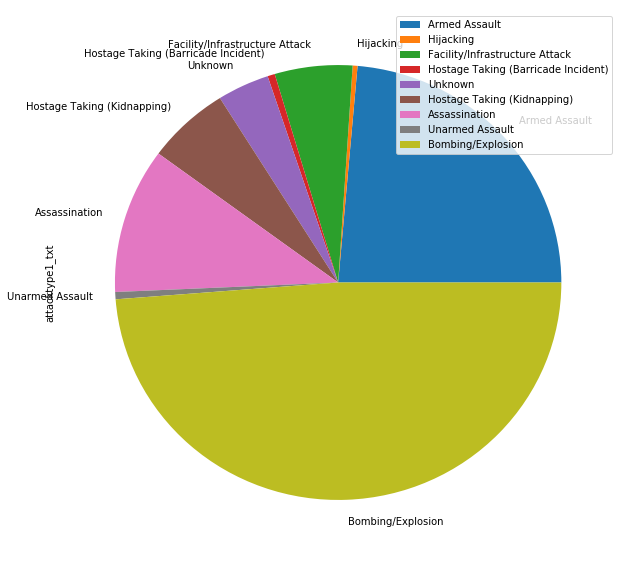

In [35]:
# AttackType
gt_data_for_viz["attacktype1_txt"].value_counts(sort=False).plot.pie(figsize=(10, 10),fontsize=10,legend="true")
plt.show()

A majority of terrorist incidents involve weapons mostly bombs or other arms. 

Attack Type is a reliable feature as there is more classified data then unknown data.

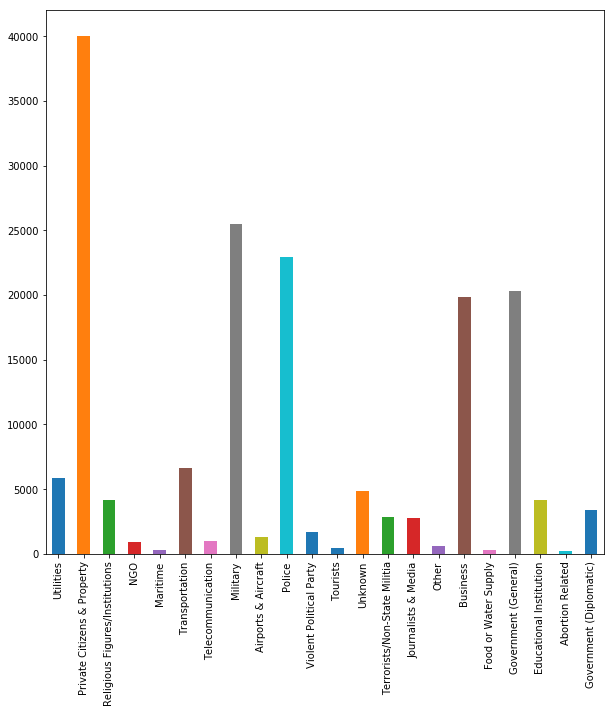

In [36]:
# Targ Type
gt_data_for_viz["targtype1_txt"].value_counts(sort=False).plot(kind="bar",figsize=(10, 10))
plt.show()

A majority of terrorist incidents target private citizens and property and the military. These incidents seem to target other Militant/Authoritative institutions such as the police, the government, and non state militias. 

Target Type is reliable as a feature in the data because there is more recorded data then unknown data.

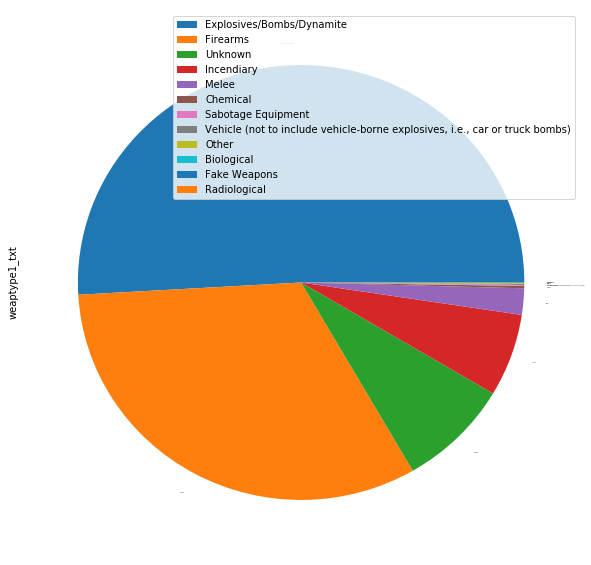

In [37]:
# Weapon Type
gt_data_for_viz["weaptype1_txt"].value_counts(sort=True).plot.pie(figsize=(10, 10),fontsize=0,legend="true")
plt.show()

Coinciding with Attack Types, most terrorist incidents involve explosives/bombs.

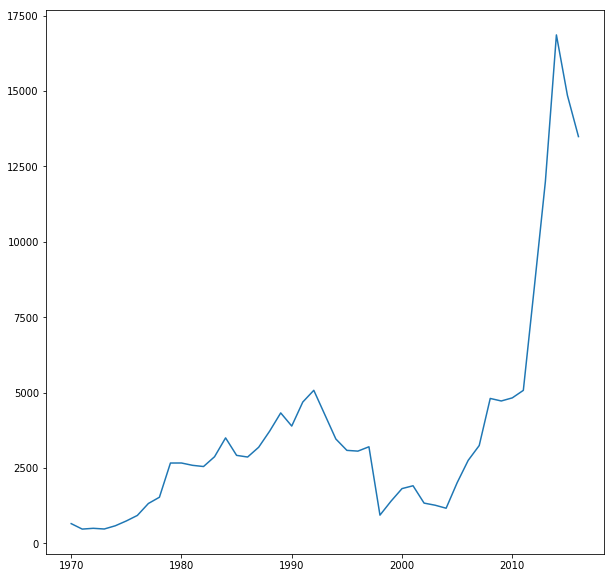

In [38]:
# Recorded Terrorist Incidents per year
gt_data_for_viz["iyear"].value_counts().sort_index().plot(figsize=(10, 10))
plt.show()

Unfortunately, there is an upwards trend in the number of terrorist incidents as time goes on.

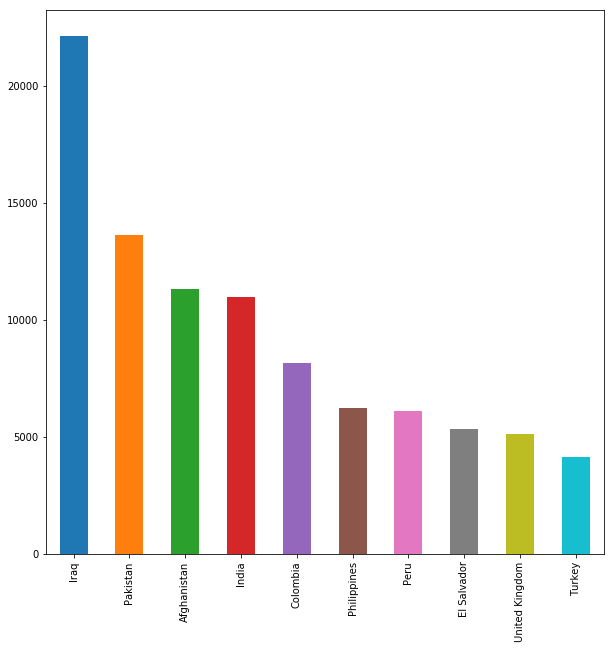

In [39]:
# Top 10 Recorded Terrorist Incidents per country
gt_data_for_viz["country_txt"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

Country is a reliable feature in the data as it has many classes and various data points for each(if not every) class

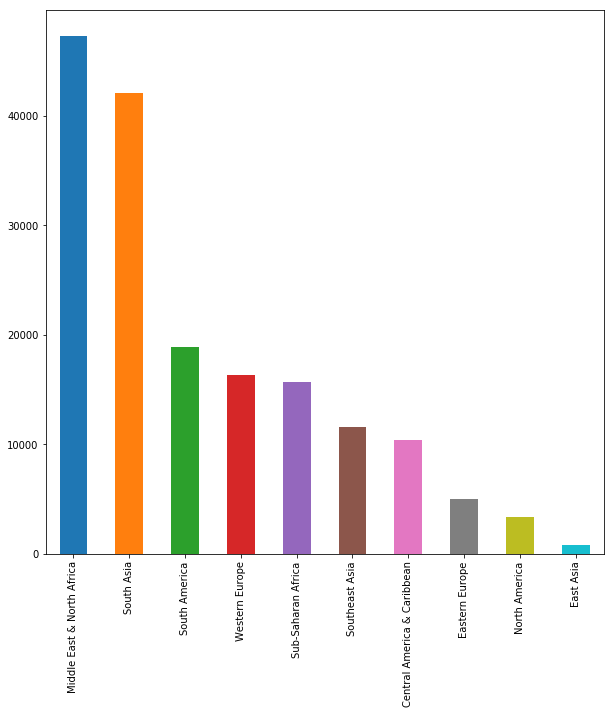

In [40]:
# Top 10 recorded terrorist incidents per city (pre imputation)
global_terrorism_data["region_txt"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

A majority of the terror incidents occur in South Asia, the Middle East and North Africa

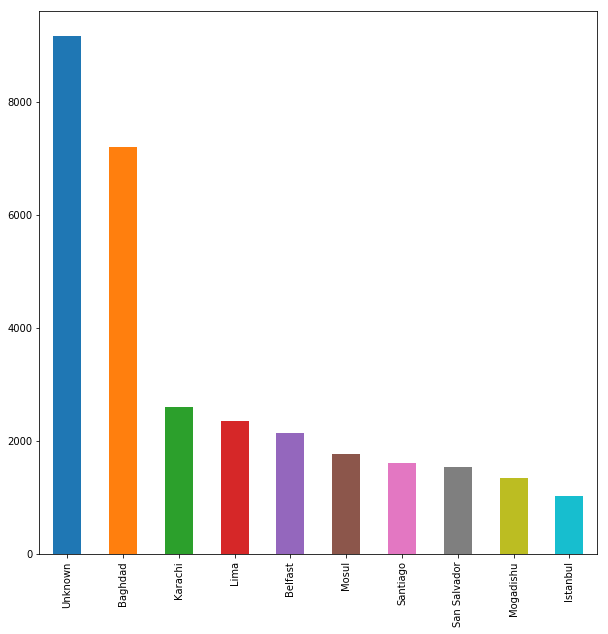

In [41]:
# Top 10 recorded terrorist incidents per city (pre imputation)
gt_data_for_viz["city"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

Prior to imputations city is a higly unreliable feature as the majority of its records are classified as unknown

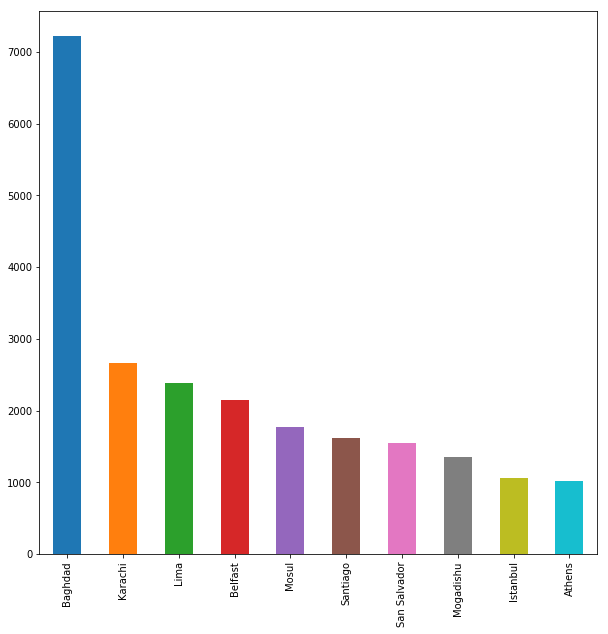

In [42]:
#Top 10 Recorded Terrorist Incidents 
# per most specified location (after imputation)
global_terrorism_data["most_specific_location"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

Note: The amount of terrorist incidents with the "Unknown" classification is no longer a significant classification given imputation. Post imputation most specified location becomes a far more reliable feature of data for use with prediction.

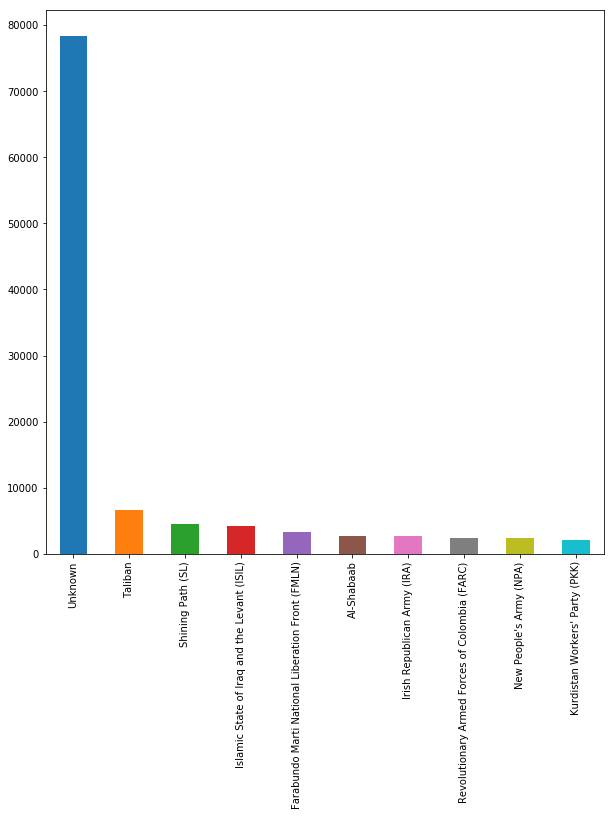

In [43]:
#Top 10 Perpetrator Groups by incidents
gt_data_for_viz["gname"].value_counts().head(10).plot(kind="bar",figsize=(10, 10))
plt.show()

A majority of the perpetrators are classified as "Unknown". Our task is to be able to classify this majority into other perpetrator groups

Note: With these visualizations, notice how features in the data can partition the data into smaller and unique subsets

# 3. Training ,Testing and Evaluating Algorithms 
*  Initialized,Trained and Evaluated classifcation models to ascertain how accurate we can make our classification models before applying it to our problem

## Why K-Nearest Neighbors?
KNN is a simple classification model that is highly dependent on the calculated distance between features of a test data point and a stored data point(the neighbor(s) from the training data used in the model). There are multiple single class instances within our GTD dataset(e.g., One time terrorist groups, City's that have been attacked once, etc.). By setting the algorithm to classify the test data points based on the single most similar neighbor we should be able to classify those instances with high accuracy. KNN also returns the stored data point which we will use later for evaluation.

In [44]:
# Initialize KNN Classifier
knn_model = KNeighborsClassifier(n_neighbors=1)
# Train the model
knn_model.fit(training_data[predictor_factors],training_data["gnumber"])

# Predict classes for
# test data
knn_pred = knn_model.predict(test_data[predictor_factors])
# Predict classes for
# purely unknown 
# perpetrators
knn_unknown = knn_model.predict(test_unknown[predictor_factors])

In [45]:
# Applying our model to
# less represented classes
# to determine performance
knn_other_pred = knn_model.predict(test_single_instance[predictor_factors])

## Evaluating Models
* custom function for accuracy
* accuracy score
* hamming loss

In [46]:
#Method to determine the performance of our classification models
#Does a simple comparison of predicitons and actual calculations
def print_results(predictions,data,desired_variable):
	print("Results:")
	print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
	.format(
		data.shape[0],
		(data[desired_variable] != predictions).sum(),
		100*(1-(data[desired_variable] != predictions).sum()/data.shape[0])
		)
	)

In [47]:
print("KNN: ")
print_results(knn_pred,test_data,"gnumber")
print("Accuracy Score: ",accuracy_score(test_data["gnumber"],knn_pred))
print("Hamming Loss: ",hamming_loss(test_data["gnumber"],knn_pred))

KNN: 
Results:
Number of mislabeled points out of a total 137887 points : 11203, performance 91.88%
Accuracy Score:  0.918752311676
Hamming Loss:  0.0812476883245


In [48]:
print("KNN Unknown: ")
print_results(knn_unknown,test_unknown,"gnumber")
print("Accuracy Score: ",accuracy_score(test_unknown["gnumber"],knn_unknown))
print("Hamming Loss: ",hamming_loss(test_unknown["gnumber"],knn_unknown))

KNN Unknown: 
Results:
Number of mislabeled points out of a total 78308 points : 4451, performance 94.32%
Accuracy Score:  0.943160341217
Hamming Loss:  0.0568396587833


In [49]:
print("KNN Single Instance: ")
print_results(knn_other_pred,test_single_instance,"gnumber")
print("Accuracy Score: ",accuracy_score(test_single_instance["gnumber"],knn_other_pred))
print("Hamming Loss: ",hamming_loss(test_single_instance["gnumber"],knn_other_pred))

KNN Single Instance: 
Results:
Number of mislabeled points out of a total 38 points : 2, performance 94.74%
Accuracy Score:  0.947368421053
Hamming Loss:  0.0526315789474


As noted above, there are several classes with single instances. To address these instances, I refrained from using k-fold cross-validation to determine model accuracy because we would have splits that wouldn't provide an accurate representation of all classes as they appear within the data. However i did construct a test set with classes with single instances. I ran the classification model on these classes and received similar performance from the classifier.

I used a custom function in conjunction with built-in sci-kit learn classification metrics accuracy score and haming loss. Didn't use Jaccard Similarity Score since it is equivalent to the accuracy score.

When testing purely unknown perpetrators the classification model performed better due to the higher number of unknown values within the training data.

In conclusion, we are able to construct a fairly accurate predictive model that can determine the perpetrator group related to an incident. By selecting and engineering the right features we are able to construct a model with 90%+ accuracy and 8%- hamming loss.

# 4. Solving Our Problem

* Using the method from Step 3 train and test our model to predict what groups are most likely related to  terrorist incident
* Purely theoretical application
* Why the application works

In [50]:
#Use new training data that uses all classes except for the "Unknown" classifier
solution_training_data = global_terrorism_data[global_terrorism_data["gnumber"] != 2]
#test_unknown is our testing data

In [51]:
#Confirm training data is not of "Unknown" classification
solution_training_data.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,most_specific_location,msl_number,gnumber
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,Santo Domingo,0,0
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,Mexico city,1,1
5,197001010002,1970,1,1,NaN,0,NaT,217,United States,1,North America,Illinois,Cairo,37.005105,-89.176269,1.0,0,NaN,1/1/1970: Unknown African American assailants ...,1,1,1,0,NaN,NaN,0,1,0,2,Armed Assault,NaN,NaN,NaN,NaN,3,Police,22.0,"Police Building (headquarters, station, school)",Cairo Police Department,Cairo Police Headquarters,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Black Nationalists,NaN,NaN,NaN,NaN,NaN,To protest the Cairo Illinois Police Deparment,0.0,NaN,NaN,0,-99.0,-99.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,5.0,Unknown Gun Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Several gunshots were fired.,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"The Cairo Chief of Police, William Petersen, r...","""Police Chief Quits,"" Washington Post, January...","""Cairo Police Chief Quits; Decries Local 'Mili...","Christopher Hewitt, ""Political Violence and Te...",Hewitt Project,-9,-9,0,-9,NaN,Cairo,5,3
6,197001020001,1970,1,2,NaN,0,NaT,218,Uruguay,3,South America,Montevide

In [52]:
# Our KNN Implementation to solve
# the problem
knn_solution_model = KNeighborsClassifier(n_neighbors=1)
# Train the model
knn_solution_model.fit(solution_training_data[predictor_factors],solution_training_data["gnumber"])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [53]:
# Small Test Data of unknown perpetrators
small_test_unknown = test_unknown.sample(frac=0.05,replace=False)

In [54]:
# Test Data of all unknown perpetrators
complete_test_unknown = test_unknown.sample(frac=1.0,replace=False)

In [55]:
# returns the distances and indices 
# of the nearest neighbors for the small
# test data
distances, indices = knn_solution_model.kneighbors(small_test_unknown[predictor_factors])

In [56]:
# a look at our small data set
small_test_unknown.head(3)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,most_specific_location,msl_number,gnumber
121714,201310050020,2013,10,5,NaN,0,NaT,153,Pakistan,6,South Asia,Balochistan,Hoshab,26.004724,63.881794,1.0,1,NaN,10/05/2013: Assailants attacked Pakistani secu...,1,1,0,1,1.0,Insurgency/Guerilla Action,0,0,0,2,Armed Assault,NaN,NaN,NaN,NaN,4,Military,34.0,"Military Personnel (soldiers, troops, officers...",Pakistan Armed Forces,Soldiers,153.0,Pakistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,Firearms,5.0,Unknown Gun Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Pakistan: Security forces under attack in Awa...","""Security forces once again come under fire in...","""Security forces once again come under fire in...",START Primary Collection,-9,-9,0,-9,NaN,Hoshab,24621,2
108564,201206150021,2012,6,14,NaN,0,NaT,4,Afghanistan,6,South Asia,Nangarhar,Fateh Abad,34.358317,70.223408,2.0,0,On the road in area of Surkh Roddistrict,06/14/2012: A police vehicle struck a roadside...,1,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,3,Police,25.0,Police Security Forces/Officers,Afghan Border Police (ABP),Officers,4.0,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives/Bombs/Dynamite,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A roadside bomb was used in the attack.,3.0,0.0,0.0,1.0,0.0,0.0,1,3.0,Minor (likely < $1 million),-99.0,A police vehicle was damaged in this attack.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""IED explosion kill 3 Afghan police officers i...","""Three border cops killed in Nangarhar blast,""...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Fateh Abad,16550,2
91355,200904130015,2009,4,13,NaN,0,NaT,205,Thailand,5,Southeast Asia,Bangkok,Bangkok,13.727896,101.178976,3.0,0,The attack took place in Bangkok.,"04/13/2009: On Monday, 16 buses were burned an...",1,1,1,0,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,19,Transportation,99.0,Bus (excluding tourists),Bangkok City Transportation,Bangkok city buses,205.0,Thailand,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,The attack was carried out to protest against ...,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incendiary,18.0,Arson/Fire

In [57]:
# Method to evaluate the KNN
# classifier based on equivalency
# between test data and training 
# data
def evaluate_knn(training_data,test_data,kneighbor_indices,features_of_evaluation):
    matched_points = 0
    total_points = 0
    test_index = 0
    average_equivalency = 0
    case_m_points = 0
    case_total_points = 0
    least_accurate = 0
    most_accurate = 0
    least_index = 0
    least_test_index = 0
    case_array = []
    for index in kneighbor_indices:
        # Compares all features of test data
        # and its neighbor/training data
        # When equivalent increase matched point
        # else test other feature
        for feature in features_of_evaluation:
            train_row = training_data.iloc[index]
            test_row = test_data.iloc[test_index]
            test_value = test_row[feature]
            train_value = train_row[feature].item()
            if train_value == test_value:
                matched_points = matched_points + 1
                case_m_points = case_m_points + 1
                total_points = total_points + 1
                case_total_points = case_total_points + 1
            else:
                case_total_points = case_total_points + 1
                total_points = total_points + 1
        # Calculate 
        case_equivalency = case_m_points/case_total_points * 100
        case_array.append(case_equivalency)
        case_m_points = 0
        case_total_points = 0
        if test_index == 0:
            least_accurate = case_equivalency
            least_index = index
            most_accurate = case_equivalency
        else:
            if case_equivalency > most_accurate:
                most_accurate = case_equivalency
            if least_accurate > case_equivalency:
                least_accurate = case_equivalency
                least_index = index
                least_test_index = test_index
        test_index = test_index + 1
    equivalency_of_knn = matched_points/total_points * 100
    print("Overall Equivalence: ",equivalency_of_knn," %")
    print("Case Equivalence Counts")
    unique_acc = set(case_array)
    for acc in unique_acc:
        print(acc," % Count:",case_array.count(acc))
    print("Most prevalent case equivalence: ",
          max(set(case_array),
              key=case_array.count
             ),
          " %"
         )
    print("Least prevalent case equivalence: ",
          min(set(case_array),
              key=case_array.count
             ),
          " %"
         )
    print("Least Equivalent Case: ",least_accurate," %")
    print("Most Equivalent Case: ",most_accurate," %")
    print(matched_points," Matched Points out of ",total_points," Total Points")

In [58]:
print("Predictor Features Equivalence:")
evaluate_knn(solution_training_data,small_test_unknown,indices,predictor_factors)

Predictor Features Equivalence:
Overall Equivalence:  76.17624521072797  %
Case Equivalence Counts
100.0  % Count: 791
70.0  % Count: 528
40.0  % Count: 185
10.0  % Count: 1
80.0  % Count: 647
50.0  % Count: 386
20.0  % Count: 7
90.0  % Count: 773
60.0  % Count: 536
30.0  % Count: 61
Most prevalent case equivalence:  100.0  %
Least prevalent case equivalence:  10.0  %
Least Equivalent Case:  10.0  %
Most Equivalent Case:  100.0  %
29823  Matched Points out of  39150  Total Points


In [59]:
print("Test Data Point: ")
print(small_test_unknown[predictor_factors].head(1))
for index in indices:
    print()
    print("Training Data Point: ")
    print(solution_training_data.iloc[index]["gname"],
          "GNumber:",
          solution_training_data.iloc[index]["gnumber"]
         )
    print(solution_training_data.iloc[index][predictor_factors])
    break

Test Data Point: 
        iyear  country  extended  attacktype1  targtype1  weaptype1  multiple  \
121714   2013      153         0            2          4          5         0   

        success  suicide  msl_number  
121714        0        0       24621  

Training Data Point: 
128626    Baloch Liberation Front (BLF)
Name: gname, dtype: object GNumber: 128626    2803
Name: gnumber, dtype: int64
        iyear  country  extended  attacktype1  targtype1  weaptype1  multiple  \
128626   2014      153         0            2          4          6         0   

        success  suicide  msl_number  
128626        1        0       24621  


Note: Analyzing the input data (small_test_unknown) and it's nearest neighbor, notice that there are several feature similarities primarily the city number and country features.

In [60]:
# The implementation to solve our problem (KNN)
knn_solution_pred = knn_solution_model.predict(small_test_unknown[predictor_factors])
print(knn_solution_pred)

[2803 2016 2869 ...,   78 1524 3044]


In [61]:
# returns the distances and indices 
# of the nearest neighbors for the large
# test data
complete_distances, complete_indices = knn_solution_model.kneighbors(complete_test_unknown[predictor_factors])

In [62]:
print("Predictor Features Equivalence:")
evaluate_knn(solution_training_data,complete_test_unknown,complete_indices,predictor_factors)

Predictor Features Equivalence:
Overall Equivalence:  76.41454257547122  %
Case Equivalence Counts
100.0  % Count: 15719
70.0  % Count: 11148
40.0  % Count: 3618
10.0  % Count: 11
80.0  % Count: 12715
50.0  % Count: 7407
20.0  % Count: 164
90.0  % Count: 15986
60.0  % Count: 10367
30.0  % Count: 1173
Most prevalent case equivalence:  90.0  %
Least prevalent case equivalence:  10.0  %
Least Equivalent Case:  10.0  %
Most Equivalent Case:  100.0  %
598387  Matched Points out of  783080  Total Points


About 84.2 % of neighbors have 6 or more equivalent features with the test data point. On average there are 7 equivalent features between a neighbor and a test data point. On average 

In [63]:
# The implementation to solve our problem (KNN)
knn_complete_pred = knn_solution_model.predict(complete_test_unknown[predictor_factors])
print(knn_complete_pred)

[2581 2999 2724 ...,  630 3044 3044]


# 5. Conclusion

In theory, we can build an accurate classifiaction model to predict which perpetrator group is responsible for a terrorist incident. However we are not able to evaluate with certainity the accuracy of such models due to a lack of a solution data set. We can however infer from analysis that by selecting the best features within the data and supplying the proper training data to our models we can produce highly likely predicitons based on the shared characteristics of terrorist incidents.

## Going Further

If we can record future terrorist incidents and retroactively redefine past incidents so that all or most features are defined so that we can build a more accurate model without the need for imputation.